<a href="https://colab.research.google.com/github/kimkynningsrud/MasterThesis2024/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using DTW - Master Thesis 2024

To do:
- Implement other functions to measure dataset similarity
  - Look at ccf? Find some other metrics.
- Implement transfer learning framework
  - Need datasets that can be made to tensors. Currently only the stock price dataset is this way. (only if LSTM is to be used). Initially, implement other models that do not require this.


## Importing Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#!pip install dtaidistance
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import tensorflow as tf
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import correlate



warnings.filterwarnings('ignore')

## Importing Data
Here we also make sure the datasets are on the correct format to be able to go through the following functions.
Requirements:
  - Temporal sequence of interest should be in the last column.

In [2]:
# Stock prices dataset
stock_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/indexData.csv?token=GHSAT0AAAAAACML34ERF76CZOWCJEXGGYJYZNPUR6A"
stock_prices = pd.read_csv(stock_prices_url)

stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])  # Ensure the 'Date' column is in datetime format
stock_prices = stock_prices[stock_prices['Index'] == '399001.SZ']

# gold prices dataset
gold_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Gold%20Price.csv"
gold_prices = pd.read_csv(gold_prices_url)

# petrolium prices dataset
petrolium_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/PET_PRI_GND_DCUS_NUS_W.csv"
petrolium_prices = pd.read_csv(petrolium_prices_url)

# btc price dataset
btc_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/BTC-USD.csv"
btc_prices = pd.read_csv(btc_prices_url)

# dollar index value
usdollar_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/US%20Dollar%20Index%20Historical%20Data.csv"
usdollar_prices = pd.read_csv(usdollar_prices_url)

#other datasets also go here. If the list of datasets grows too long, consider urls in list.

datasets = {
    "Gold Prices": gold_prices,
    "Stock Prices": stock_prices,
    "Petrolium Prices": petrolium_prices,
    "BTC Prices": btc_prices,
    "US Dollar Index Value": usdollar_prices
}


In [3]:
stock_prices.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
52127,399001.SZ,1997-08-22,4190.759766,4278.299805,4168.089844,4242.060059,4242.012695,0.0
52128,399001.SZ,1997-08-25,4247.709961,4364.459961,4247.089844,4363.029785,4362.980957,0.0
52129,399001.SZ,1997-08-26,4373.529785,4422.500000,4346.979980,4386.520020,4386.471191,0.0
52130,399001.SZ,1997-08-27,4374.020020,4411.140137,4339.459961,4408.390137,4408.340332,0.0
52131,399001.SZ,1997-08-28,4408.580078,4468.870117,4373.450195,4438.319824,4438.270020,0.0


In [4]:
gold_prices.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [5]:
# moving the "A1" to the back of the dataframe as this is needed for the DTW. "A1" is the temporal column of interest.
A1col = petrolium_prices.pop("A1")
petrolium_prices.insert(len(petrolium_prices.columns), "A1", A1col)
petrolium_prices.head()

,Date,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1,A1
0,01/02/1995,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104,1.127
1,01/09/1995,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102,1.134
2,01/16/1995,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100,1.126
3,01/23/1995,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095,1.132
4,01/30/1995,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090,1.131


In [6]:
open_p = btc_prices.pop("Open")
btc_prices.insert(len(btc_prices.columns), "Open", open_p)
btc_prices.tail()


,Date,High,Low,Close,Adj Close,Volume,Open
3223,2023-07-15,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,30331.783203
3224,2023-07-16,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,30297.472656
3225,2023-07-17,30336.400391,29685.783203,30145.888672,30145.888672,13240156074,30249.626953
3226,2023-07-18,30233.656250,29556.427734,29856.562500,29856.562500,13138897269,30147.070313
3227,2023-07-20,30224.115234,29918.281250,30189.902344,30189.902344,11906640896,29919.064453


In [7]:
usdprice = usdollar_prices.pop("Price")
usdollar_prices.insert(len(usdollar_prices.columns), "Price", usdprice)
usdollar_prices.tail()

,Date,Open,High,Low,Change %,Price
5618,"Sep 15, 2022",109.60,109.92,109.42,0.19%,109.80
5619,"Sep 16, 2022",109.80,110.26,109.48,-0.14%,109.64
5620,"Sep 18, 2022",109.64,109.74,109.50,-0.08%,109.55
5621,"Sep 19, 2022",109.55,110.18,109.49,-0.01%,109.54
5622,"Sep 20, 2022",109.54,110.23,109.36,0.53%,110.12


## Pre-processing

In [8]:
def convert_dates(df, date_column='Date'):
    """
    Converts the date column to datetime format, relying on Pandas to infer the date format.

    :param df: Pandas DataFrame containing the financial data.
    :param date_column: Name of the column containing date information.
    :return: DataFrame with the converted date column.
    """
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

def trim_dataset_to_timeframe(df, date_column='Date', start_year=2015, end_year=2020):
    """
    Trims the dataset to include data only between the specified start and end years.

    :param dataset: Pandas DataFrame containing the data.
    :param date_column: The name of the column containing the date information.
    :param start_year: The start year for the timeframe.
    :param end_year: The end year for the timeframe.
    :return: Trimmed DataFrame.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the dataset based on the date range
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return df


def handle_missing_values(df):
    """
    Detects and removes missing values.

    :param df: Pandas DataFrame.
    :return: DataFrame after removing missing values.
    """
    NA_values_before = df.isna().sum().sum()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    NA_values_after = df.isna().sum().sum()

    print(f'There are {NA_values_before} NA values in the dataset. {NA_values_after} after removing them.')

    return df

def standardize(df, date_column='Date'):
    """
    Scales numerical columns except the date column.

    :param df: Pandas DataFrame.
    :param date_column: Name of the column containing date information to exclude from scaling.
    :return: Scaled DataFrame.
    """
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns.drop(date_column, errors='ignore')  # Exclude date column if present

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

def trim_to_date_and_last_column(df):
    """
    Keeps only the 'Date' column and the last column in the DataFrame.

    :param df: Pandas DataFrame to trim.
    :return: Trimmed DataFrame with only the 'Date' column and the last data column.
    """
    if 'Date' in df.columns and len(df.columns) > 1:
        # Selecting only the 'Date' column and the last column of the DataFrame
        return df[['Date', df.columns[-1]]]
    else:
        print("Error: DataFrame must contain a 'Date' column and at least one other column.")
        return None  # Returning None to indicate that the required condition is not met



def normalize_minmax(df, columns=None):
    """
    Normalizes the specified columns of a DataFrame using Min-Max scaling.

    :param df: DataFrame to be normalized.
    :param columns: List of column names to normalize. If None, all numeric columns will be normalized.
    :return: DataFrame with normalized columns.
    """
    scaler = MinMaxScaler()
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    df[columns] = scaler.fit_transform(df[columns])
    return df


def stationarize_columns(df):
    """
    Processes each numeric column in the DataFrame by checking for stationarity
    and making it stationary if needed.

    :param df: DataFrame containing the time series data.
    :return: DataFrame with all necessary columns processed for stationarity.
    """
    for column in df.select_dtypes(include=['number']).columns:
        print(f"Processing column: {column}")

        # Check for stationarity
        series = df[column]
        result = adfuller(series, autolag='AIC')
        p_value = result[1]

        if p_value < 0.05:
            print(f"Column {column} is already stationary")
        else:
            # Make the series stationary if not stationary
            print(f"Making column {column} stationary")
            df[column] = df[column].diff().dropna()

    return df



def preprocess_datasets(datasets):
    preprocessed_datasets = {}
    highest_interval = pd.Timedelta.min
    for name, df in datasets.items():
        print("_________________________________________________")
        print(f"Preprocessing {name}")
        preprocessed_df = convert_dates(df)
        preprocessed_df = handle_missing_values(preprocessed_df)
        preprocessed_df = trim_to_date_and_last_column(preprocessed_df)
        preprocessed_df = trim_dataset_to_timeframe(preprocessed_df)
        preprocessed_df = normalize_minmax(preprocessed_df)
        #preprocessed_df = standardize(preprocessed_df)
        preprocessed_df = stationarize_columns(preprocessed_df)

        preprocessed_datasets[name] = preprocessed_df

    return preprocessed_datasets

In [9]:
# Preprocess all datasets
preprocessed_datasets = preprocess_datasets(datasets)



_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
Processing column: Chg%
Column Chg% is already stationary
_________________________________________________
Preprocessing Stock Prices
There are 1008 NA values in the dataset. 0 after removing them.
Processing column: Volume
Making column Volume stationary
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
Processing column: A1
Making column A1 stationary
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
Processing column: Open
Making column Open stationary
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
Processing column: Price
Column Price is already stationary


## Plotting after preprocessing

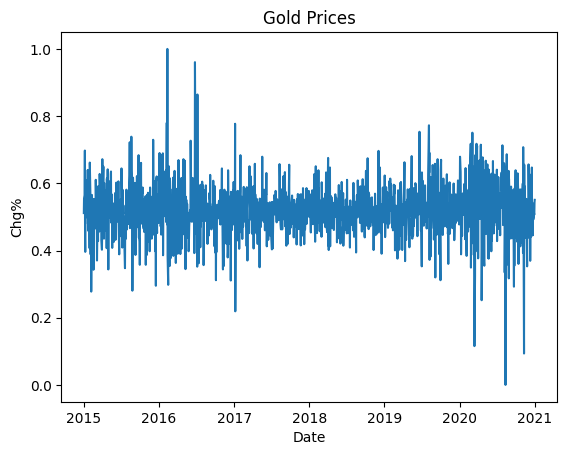

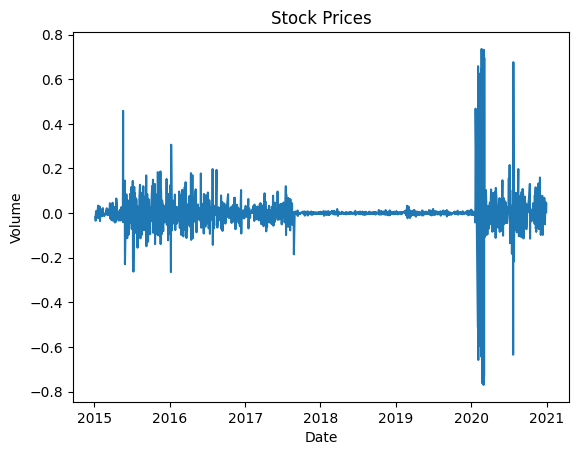

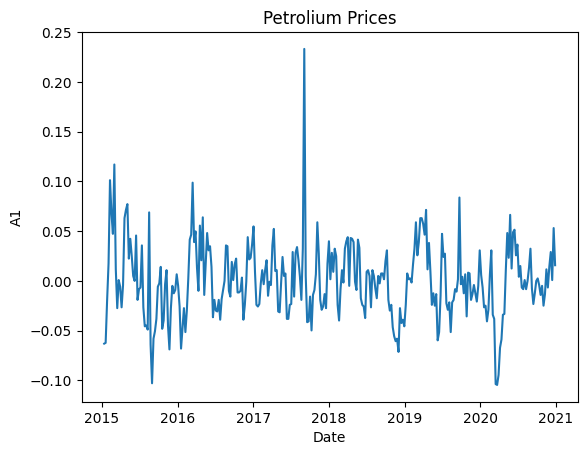

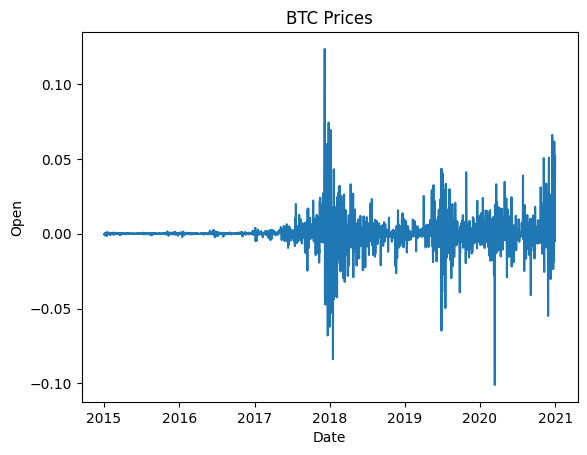

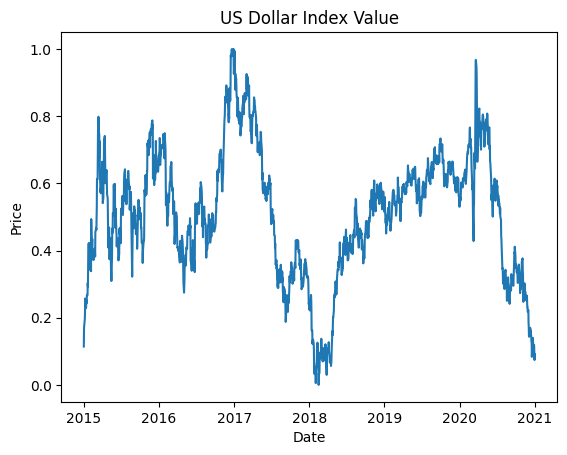

In [10]:
def plot_datasets(datasets):
    """
    Automatically plots each dataset with 'Date' on the x-axis and the last column on the y-axis.

    :param datasets: Dictionary of preprocessed datasets with their names as keys.
    """
    for name, df in datasets.items():
        plt.figure()
        last_column = df.columns[-1]  # Assuming the last column is the one to be plotted
        sns.lineplot(data=df, x='Date', y=last_column).set(title=f"{name}")
        plt.show()

# Run the function for all the datasets
plot_datasets(preprocessed_datasets)


## Dynamic Time Warping (DTW)

In [11]:
def compare_datasets_with_dtw(datasets):
    """
    Compares each dataset to every other dataset using Dynamic Time Warping (DTW).
    Assumes the column of interest is the last one in each dataset.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :return: A DataFrame of DTW distances between each pair of datasets.
    """
    dataset_names = list(datasets.keys())
    n = len(dataset_names)
    dtw_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[dataset_names[i]].iloc[:, -1].dropna().values
            series_j = datasets[dataset_names[j]].iloc[:, -1].dropna().values
            distance = dtw.distance(series_i, series_j)
            dtw_matrix[i, j] = dtw_matrix[j, i] = distance

    return pd.DataFrame(dtw_matrix.round(2), index=dataset_names, columns=dataset_names)

# Use the function on the preprocessed datasets
dtw_df = compare_datasets_with_dtw(preprocessed_datasets)


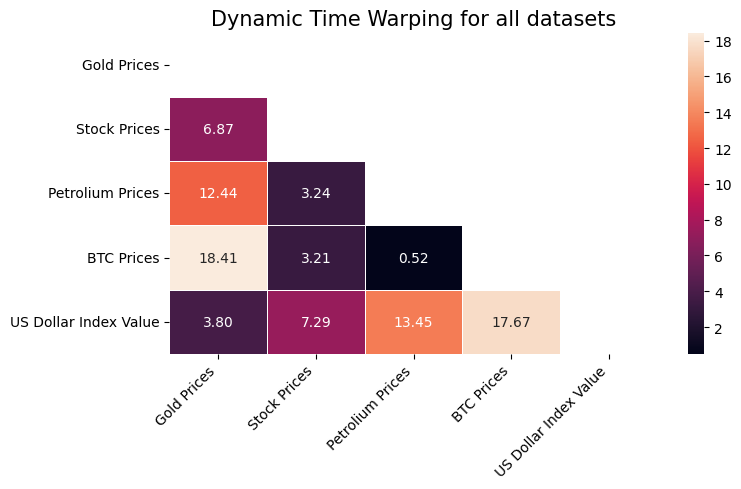

In [12]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(dtw_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Dynamic Time Warping for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Cross-correlation

In [13]:
def compare_datasets_with_cross_correlation(datasets):
    """
    Compares each dataset to every other dataset using cross-correlation.
    Assumes the column of interest is the last one in each dataset.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :return: A DataFrame of cross-correlation scores between each pair of datasets.
    """
    dataset_names = list(datasets.keys())
    n = len(dataset_names)
    cross_corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[dataset_names[i]].iloc[:, -1].dropna().values
            series_j = datasets[dataset_names[j]].iloc[:, -1].dropna().values

            # Compute cross-correlation
            corr = correlate(series_i, series_j, mode='full')
            max_corr = np.max(corr)
            cross_corr_matrix[i, j] = cross_corr_matrix[j, i] = max_corr

    return pd.DataFrame(cross_corr_matrix.round(2), index=dataset_names, columns=dataset_names)

cross_corr_df = compare_datasets_with_cross_correlation(preprocessed_datasets)

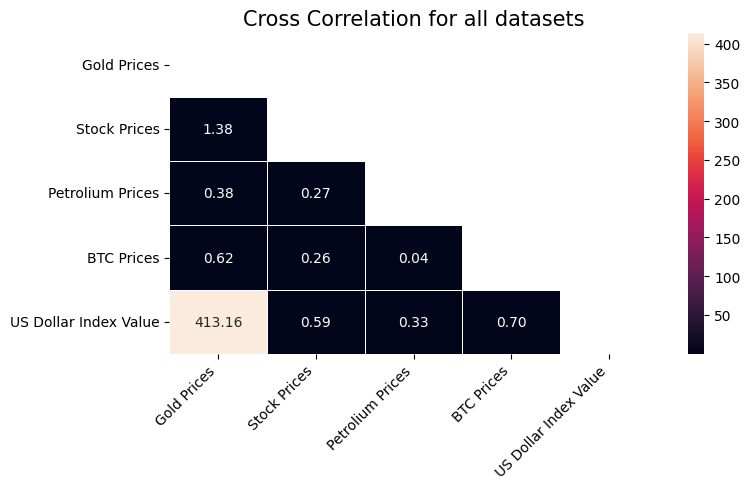

In [14]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(cross_corr_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Cross Correlation for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Test-Train split

In [15]:
# Function to prepare the data for RNN
def prepare_rnn_data(df, time_steps=1):
    """
    Converts the DataFrame into two arrays X and y, where X is an array of sequences of past observations
    and y is the array of corresponding future values that we want to predict.
    """
    df = df.iloc[:, -1].values  # Using only the last column
    df = df.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i, 0])
        y.append(df[i, 0])

    return np.array(X), np.array(y)

# Function to split datasets into train and test
def split_datasets(datasets, time_steps, test_size=0.2):
    train_test_split_datasets = {}
    for name, df in datasets.items():
        X, y = prepare_rnn_data(df, time_steps)
        X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for RNN
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
        train_test_split_datasets[name] = (train_X, train_y, test_X, test_y)
    return train_test_split_datasets

## Model Creation

In [16]:
# Function to create an RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the RNN model using transfer learning
def train_with_transfer_learning(split_datasets, base_model=None):
    trained_models = {}
    for name, (train_X, train_y, test_X, test_y) in split_datasets.items():
        print(f"Training on {name}")

        # If it's the first model, create a new one; otherwise, use the base model
        if base_model is None:
            model = create_rnn_model(train_X.shape[1:])  # input_shape is the shape of X excluding the sample axis
        else:
            model = tf.keras.models.clone_model(base_model)
            # Re-compile the model after cloning
            model.compile(optimizer='adam', loss='mean_squared_error')

        early_stopping = EarlyStopping(monitor='val_loss', patience=15)
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, callbacks=[early_stopping])

        trained_models[name] = model
        base_model = model  # Update the base model for transfer learning

    return trained_models

# Define time_steps (how many past observations to use for prediction)
time_steps = 5  # Adjust this based on your specific datasets

# Split the datasets
split_data = split_datasets(preprocessed_datasets, time_steps)

# Train the models using transfer learning
trained_models = train_with_transfer_learning(split_data)


Training on Gold Prices
Epoch 1/10
39/39 [==============================] - 6s 43ms/step - loss: 0.0454 - val_loss: 0.0107
Epoch 2/10
39/39 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0103
Epoch 3/10
39/39 [==============================] - 1s 16ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 4/10
39/39 [==============================] - 1s 16ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 5/10
39/39 [==============================] - 1s 17ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 6/10
39/39 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 0.0100
Epoch 7/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 8/10
39/39 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 9/10
39/39 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 10/10
39/39 [==============================] - 0s 11ms/step - loss: 0.0053 - val

In [17]:
def evaluate_models_on_test_data(trained_models, split_datasets):
    evaluation_results = {}
    for train_name, model in trained_models.items():
        evaluation_results[train_name] = {}
        for test_name, (test_X, test_y, _, _) in split_datasets.items():
            # Drop NaNs in test_X and test_y
            valid_idx = ~np.isnan(test_X).any(axis=(1, 2)) & ~np.isnan(test_y)
            test_X, test_y = test_X[valid_idx], test_y[valid_idx]

            # Make predictions and handle NaNs
            predictions = np.nan_to_num(model.predict(test_X))

            # Calculate metrics
            evaluation_results[train_name][test_name] = {
                'MSE': mean_squared_error(test_y, predictions),
                'RMSE': np.sqrt(mean_squared_error(test_y, predictions)),
                'MAE': mean_absolute_error(test_y, predictions),
                'R2': r2_score(test_y, predictions)
            }

    return evaluation_results

# Evaluate the models on test data
evaluation_results = evaluate_models_on_test_data(trained_models, split_data)



40/40 [==============================] - 0s 3ms/step


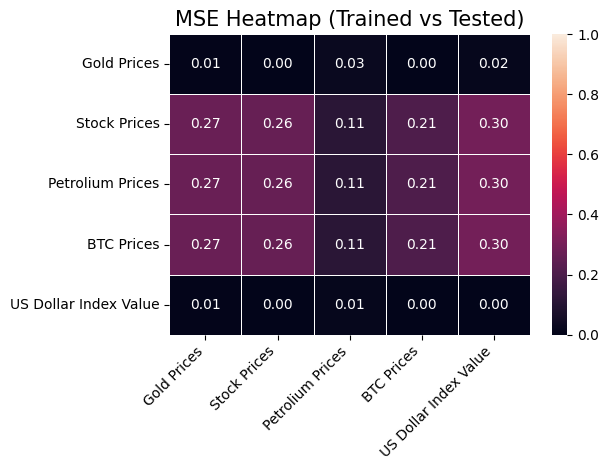

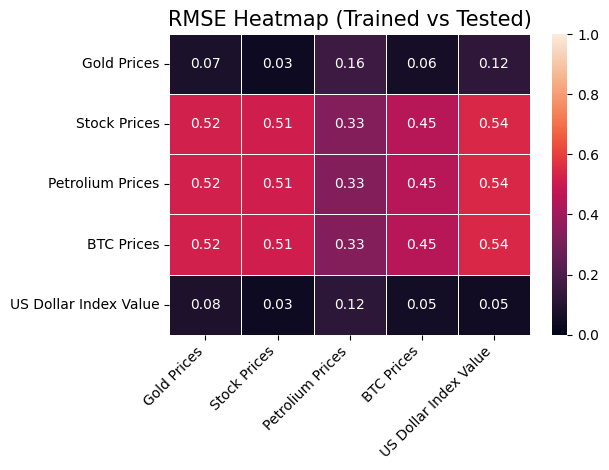

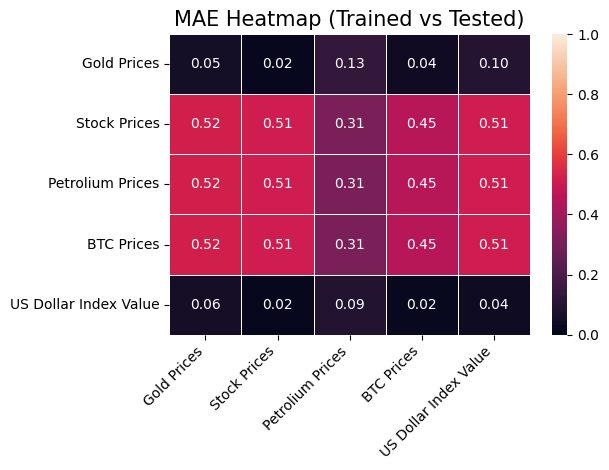

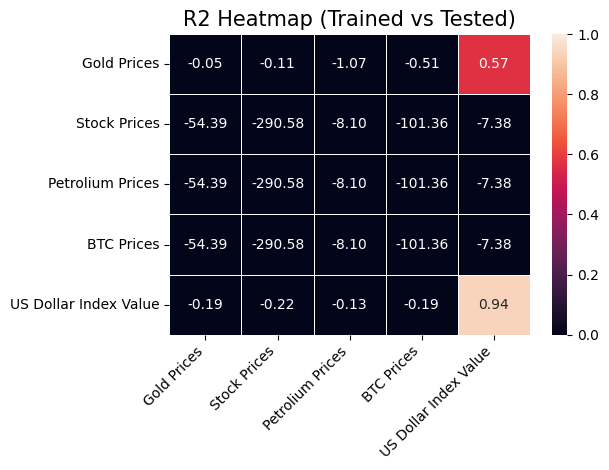

In [18]:
# Initialize empty DataFrames for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
metric_dfs = {metric: pd.DataFrame(index=evaluation_results.keys(), columns=evaluation_results.keys()) for metric in metrics}

# Populate the DataFrames with evaluation results
for train_name in evaluation_results:
    for test_name in evaluation_results[train_name]:
        for metric in metrics:
            metric_dfs[metric].loc[train_name, test_name] = evaluation_results[train_name][test_name][metric]

# Generate heatmaps for each metric
def generate_heatmap(df, title):
    plt.figure()
    sns.heatmap(df, annot=True, fmt=".2f", linewidths=.5, cbar=True, vmin=0, vmax=1)
    plt.title(title, fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

for metric, df in metric_dfs.items():
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
    generate_heatmap(df, f"{metric} Heatmap (Trained vs Tested)")
